# Lab 2: Exponential Random Graph Models (ERGMs)

#### Code Source / Reference
Check here for more details about the pyERGM package: https://github.com/mallaham/pyERGM

#### Install necessary libraries
You only need to run this once (the first time you use this script)

In [11]:
#!pip3 install git+https://github.com/mallaham/pyERGM
# !pip3 install networkx
# !pip3 install matplotlib


In [12]:
#!pip3 install git+https://github.com/mallaham/pyERGM

#### Check/set the working directory

In [13]:
#!pwd  
#!ls   # ensure all of the lab files are in your current working directory

#### Import all pyERGM libraries

In [14]:
import pyergm
from pyergm import rpy_interface as rpyInterface
from pyergm.network_statistics import NetworkStats
from pyergm.ergm import pyERGM, ModelDiagnostics
from pyergm.simulator import Simulator
from pyergm.data_transformer import DataTransformer
import pandas as pd
from rpy2.robjects import NA_Real
import numpy as np
import networkx as nx

In [15]:
rpackages = ['statnet', 'ergm','texreg', 'base', 'grDevices'] # removing igraph because it causes issues with ergm native functions
renv = rpyInterface.intializeRenv(mirror=1, r_packages= rpackages)
installed_packages = renv.setup_renv()

Installing R packages...
Importing package: statnet
Importing package: ergm
Importing package: texreg
Importing package: base
Importing package: grDevices


### PART I: Building and Visualizing the Networks

In [42]:
################################
## Dependent variable
################################
# Responses to the question:
# “List up to 5 employees who you rely on the most for help or advice at work.” 
# Note that participants were limited to selecting at most five respondents.
adviceEdgelist = pd.read_csv("adviceEdgelist.csv")
#print(adviceEdgelist.head())

################################
## Independent variables
################################
# Load node attributes, and store them in the advice network object we have created
dt = DataTransformer(renv)
department = dt.rdf_to_list(dt.to_rdf(pd.read_csv("departmentNode.csv")), "department")
leader = dt.rdf_to_list(dt.to_rdf(pd.read_csv("leaderNode.csv")),"leader")
tenure = dt.rdf_to_list(dt.to_rdf(pd.read_csv("tenureNode.csv")), "tenure")
office = dt.rdf_to_list(dt.to_rdf(pd.read_csv("officeNode.csv")), "office")
female = dt.rdf_to_list(dt.to_rdf(pd.read_csv("femaleNode.csv")), "female")

# converting pandas dataframe to r
r_adviceEdgelist = dt.to_rdf(adviceEdgelist)

# loading edgelist as a matrix
advice = dt.edgelist_to_matrix(r_adviceEdgelist)
# print("ADVICE:\n", type(advice), advice)

Converting pandas DataFrame to R dataframe...
Converting R dataframe to R list...
Converting pandas DataFrame to R dataframe...
Converting R dataframe to R list...
Converting pandas DataFrame to R dataframe...
Converting R dataframe to R list...
Converting pandas DataFrame to R dataframe...
Converting R dataframe to R list...
Converting pandas DataFrame to R dataframe...
Converting R dataframe to R list...
Converting pandas DataFrame to R dataframe...
Generating a matrix from edgelist...


/Users/juliachu/opt/miniconda3/envs/pyergm_venv/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/Users/juliachu/opt/miniconda3/envs/pyergm_venv/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/Users/juliachu/opt/miniconda3/envs/pyergm_venv/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/Users/juliachu/opt/miniconda3/envs/pyergm_venv/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/Users/juliachu/

In [50]:

# Set network attributes
advice = dt.set_vertex_attribute(advice, ["department","leader","tenure","office","female"], [department, leader, tenure, office, female])
# alternative method
# advice = dt.set_vertex_attribute(advice, "department", department) # Categorical variable for department
# advice = dt.set_vertex_attribute(advice, "leader", leader) # Indicator variable for department leader
# advice = dt.set_vertex_attribute(advice, "tenure",tenure) # Years tenure
# advice = dt.set_vertex_attribute(advice, "office", office) # Indicator variable for whether they are located in the main or secondary office
# advice = dt.set_vertex_attribute(advice, "female",female) # Indicator

# Finally, we will import data on the counts of direct messages sent between two employees
# The file "messageEdgelist.csv" contains a messaging edgelist, that we will convert to a matrix
messageEdgeList = pd.read_csv("messageEdgelist.csv")
messageEdgeList

A list of attribute names and values was passed...
Setting vertex attribute to department...
Setting vertex attribute to leader...
Setting vertex attribute to tenure...
Setting vertex attribute to office...
Setting vertex attribute to female...


,SenderId,ReceiverId,MessagesSent
0,15,15,2
1,15,23,18
2,15,19,0
3,15,63,3
4,15,49,31
...,...,...,...
4351,16,9,0
4352,16,28,0
4353,16,58,0
4354,16,3,0


In [51]:
cov_matrix = dt.cov_matrix(messageEdgeList, 'SenderId',' ReceiverId', 66, 66, NA_Real)

# Fill matrix with values
for index, row in messageEdgeList.iterrows():
    s_idx = int(row['SenderId'])
    r_idx = int(row['ReceiverId'])
    cov_matrix.rx[renv.load_robject('cbind')(s_idx,r_idx)] = float(row['MessagesSent']/100)   # Change weights to represent hundred of messages sent
                                                                                              # This will make viewing/interpreting ergm coefficients easier

Generating covariance matrix for: None
Importing package: base
No covariance column was passed. Returning a matrix with populated values of NA_real_


In [38]:
cov_matrix

0.020000,0.010000,0.000000,...,0.000000,0.060000,0.000000


In [17]:
################################
## Basic descriptive information of the advice network
################################
ns = NetworkStats(renv)
summary_network = ns.summary(advice)
print(summary_network)

network_size = ns.network_size(advice)
print(network_size)

betweeness = ns.betweeness(advice)
print(betweeness)

isolates = ns.isolates(advice)
print(isolates)

Calculating network summary statistics...
Network attributes:
  vertices = 66
  directed = TRUE
  hyper = FALSE
  loops = FALSE
  multiple = FALSE
  bipartite = FALSE
 total edges = 225 
   missing edges = 0 
   non-missing edges = 225 
 density = 0.05244755 

Vertex attributes:

 department:
   character valued attribute
   attribute summary:
   BE    ME     O     P     S Sales    TI    WB    WF 
   10    18     2    13     5     1     9     1     7 

 female:
   integer valued attribute
   66 values

 leader:
   integer valued attribute
   66 values

 office:
   integer valued attribute
   66 values

 tenure:
   numeric valued attribute
   attribute summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0137  0.2418  1.2356  2.1093  3.3541 11.0137 
  vertex.names:
   character valued attribute
   66 valid vertex names

No edge attributes

Network edgelist matrix:
       [,1] [,2]
  [1,]    1   31
  [2,]    1   57
  [3,]    2   31
  [4,]    2   59
  [5,]    3   24
  [6,]    3   

/Users/juliachu/opt/miniconda3/envs/pyergm_venv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


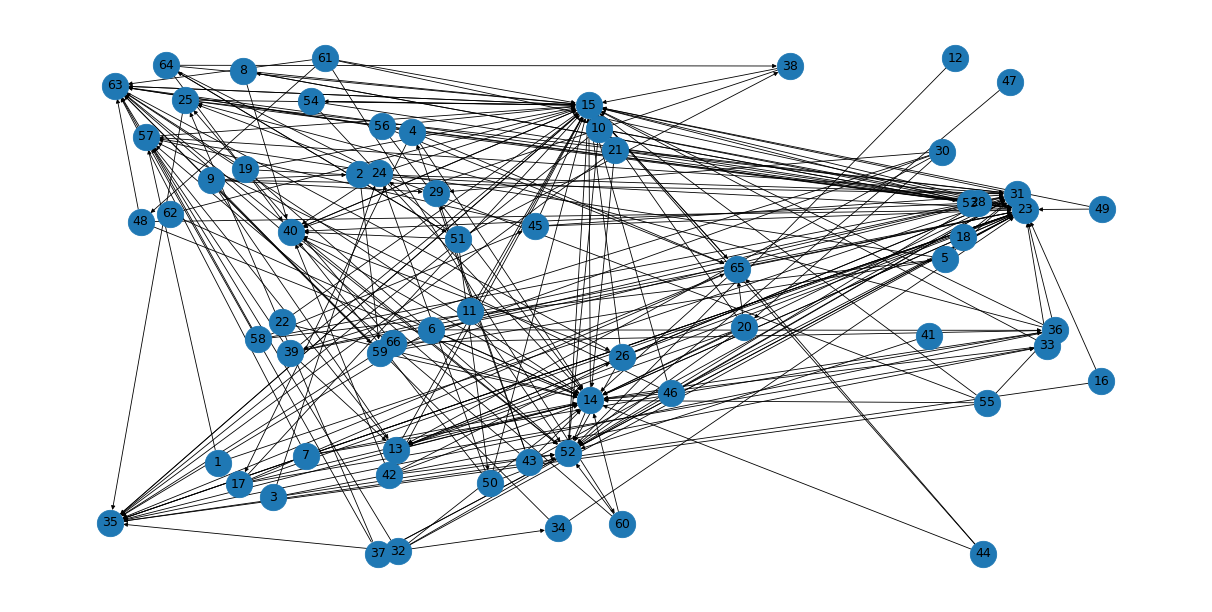

In [18]:
################################
## Visualize the Advice network
################################

# Networkx doesn't plot isolates
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

G = nx.from_pandas_edgelist(adviceEdgelist, source='SenderId', target='ReceiverId', create_using=nx.DiGraph())
# g = nx.DiGraph() 
# G.add_nodes_from(sorted(G.nodes(data=True)))
# G.add_edges_from(G.edges)
pos = nx.random_layout(G)#,k=2,scale=0.5)

# visualizations docs networkx: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
# arrow style: https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.ArrowStyle.html#matplotlib.patches.ArrowStyle
fig = plt.figure(1, figsize=(20, 10), dpi=60)
nx.draw(G, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000,pos=pos)


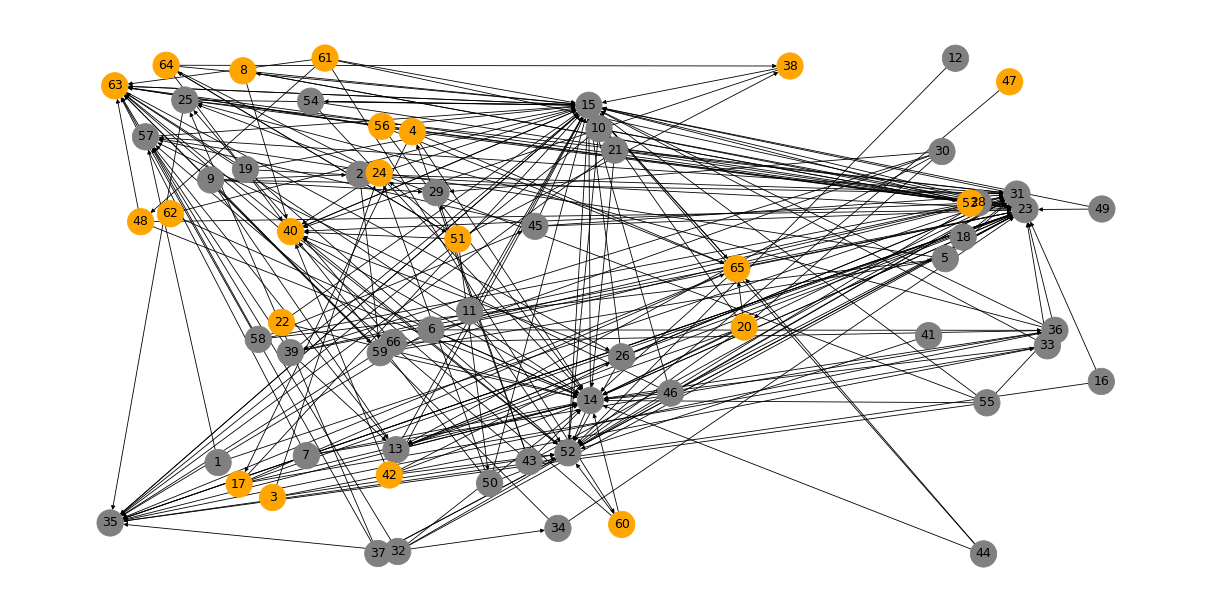

In [19]:
################################
## Visualize the Advice network with gender
################################

# labeling nodes with orange if female
female = np.array(female)
color = []
for n in G.nodes:
    val = female[n-1]
    if val == 0:
        color.append("grey")
    else:
        color.append("orange")

# visualizations docs networkx: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
# arrow style: https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.ArrowStyle.html#matplotlib.patches.ArrowStyle
fig = plt.figure(1, figsize=(20, 10), dpi=60)

# nx.draw_networkx(G,arrows=True,att)
# 0: male 1:female
# orange: famle
# red: male
#node_color=np.delete(np.array(female), 26)
nx.draw(G,with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000, pos=pos,
       node_color=color)
# nx.draw(G, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000, pos=pos)


/Users/juliachu/opt/miniconda3/envs/pyergm_venv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


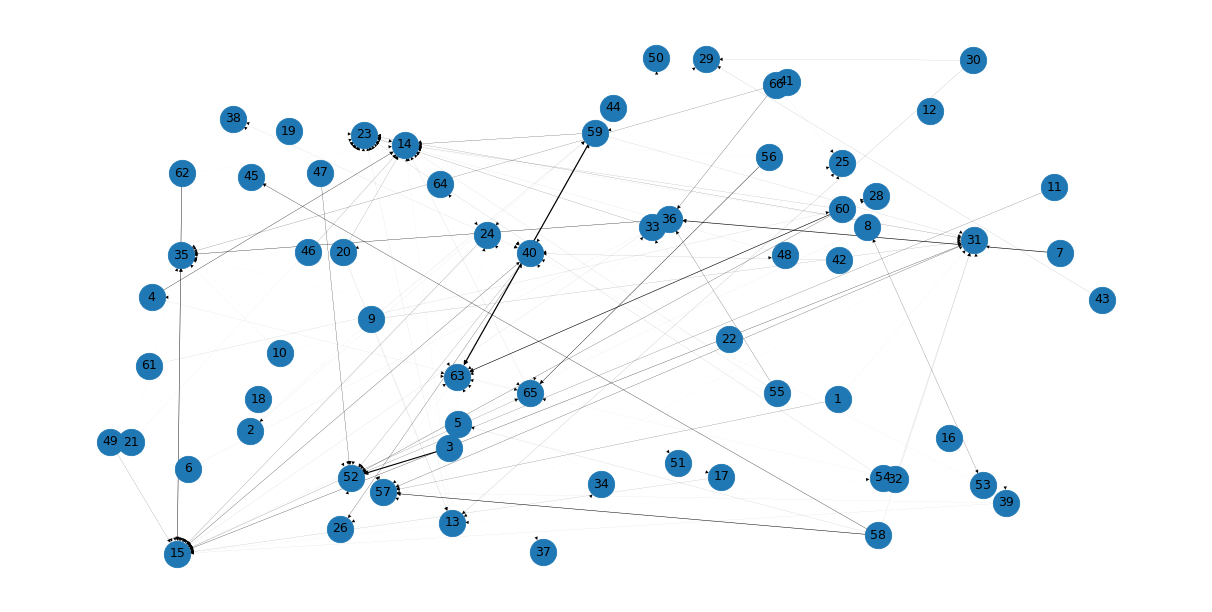

In [20]:
################################
## Visualize the Communication network
################################

# Plot the network of who messages whom
# One unit of weight is 100 messages
messageEdgeList['MessagesSent_w'] = messageEdgeList['MessagesSent'] /100
G_messages = nx.from_pandas_edgelist(messageEdgeList, source='SenderId', target='ReceiverId',create_using=nx.DiGraph())
# g = nx.DiGraph()
pos = nx.random_layout(G) 
# visualizations docs networkx: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
# arrow style: https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.ArrowStyle.html#matplotlib.patches.ArrowStyle
fig = plt.figure(1, figsize=(20, 10), dpi=60)
# Change the transparency of edges to represent the edge weight
nx.draw(G, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000,pos=pos, width=messageEdgeList['MessagesSent_w'])


### PART II: Build the ERGM Models
R vignette for details about ERGM models: https://cran.r-project.org/web/packages/ergm/ergm.pdf
and ERGM terms: https://cran.r-project.org/web/packages/ergm/vignettes/ergm-term-crossRef.html

We will use the ergm-terms to perform hypothesis testing using ERGMs. But note that any of the ERGM terms can also be examined directly for your observed network.

Reminder: Endogenous statistics are terms based on only ties in the advice network and Exogenous statistics are terms based on advice ties AND other ties / node attributes.

Before fitting the ERGM, get the counts of these patterns for the network. Fitting the ERGM model will tell you whether these counts are relatively high/low in comparison to what we would expect based on random chance, controlling for the other effects in our model. This type of analysis can be helpful for understanding your network, as well as troubleshooting issues with ERGM regression

In [40]:
print(type(cov_matrix))

<class 'rpy2.robjects.vectors.FloatMatrix'>


In [21]:
################################
## ERGM Model 1
################################
# The following commands do model estimation for ERGMs.
# This may take a second. Text will print in-console to update you on progress in model estimation.

# Formula and input variables
formula = "advice ~ edges + mutual + edgecov(hundred_messages) + nodemix('leader',base = 3)"
    # edges = this is  a tendency towards a greater number of advice ties existing. Based on a statistic counting the number of ties.
# Structural patterns:
    # mutual = this is a tendency towards reciprocity for the advice ties. Based on a statistic counting the number of reciprocated ties.
    # edgecov(hundreds_messages) = this is the effect of every 100 messages sent from i->j on likelihood of an advice tie. Based on a weighted sum of advice ties x 100s of messages sent
vars = {"advice": advice, "hundred_messages": cov_matrix}

# Model definition and parameters
ergm = pyERGM(installed_packages['ergm'], formula, vars, constraints="~bd(maxout=5)") # This constraint enforces the maximum outdegree is 5
params = dict({"formula":ergm.formula, "constraints":ergm.constraints}) # make sure to include = for parameters that require = vs parameters that can be upacked such as formula
model1 = ergm.fit_model(params)
summary_model1 = ergm.summary(model1)
print(summary_model1)

Model summary before fitting ERGM...
In term ‘nodemix’ in package ‘ergm’: Argument ‘base’ has been superseded by ‘levels2’, and it is recommended to use the latter.  Note that its interpretation may be different.
                          c(edges = 225, mutual = 12, edgecov.hundred_messages = 56.69, mix.leader.0.0 = 94, mix.leader.1.0 = 8, mix.leader.1.1 = 12)
edges                                                                225.00                                                                          
mutual                                                                12.00                                                                          
edgecov.hundred_messages                                              56.69                                                                          
mix.leader.0.0                                                        94.00                                                                          
mix.leader.1.0                       

In [22]:
## Convert a log-odds (e.g., -2.73064) ratio to an odds ratio
np.exp(-2.73064)

0.06517756267680141

In [23]:
################################
## ERGM Model 2
################################
# This model will be slower to estimate than model 1
# Expect roughly 2-7 minutes. If it gets stuck for longer than that, try stopping and re-running it

# Formula and input variables
formula = "advice ~ mutual + gwidegree(log(2), fixed = T) + gwodegree(2, fixed = T, cutoff = 5) + dgwesp(log(2), type = 'OTP', fixed = T, cutoff =5) + nodematch('female') + nodemix('leader', base = 3) + nodematch('department') + nodeicov('office') + nodeocov('office') + diff('tenure') + edgecov(hundred_messages)"
# Structural patterns:
    # mutual = this is a tendency towards reciprocity for the advice ties. Based on a statistic counting the number of reciprocated ties.
    # gwidegree = inverted preferential attachment (indegree)
    # gwodegree = inverted preferential attachment (outdegree)
    # dgwesp = a modified version of Outgoing Two Path(i->j + i->k->j) structures. Geometrically weighted version of transitivity
# Node attribute effects:
    # nodematch = Homophily on a categorical variable
    # nodemix = Mixing matrix of all different combinations of node attributes (ex. A -> A ties, A-> B ties, B -> A ties, B -> B ties).
    # nodeicov = Covariance between in-degree of nodes and attributes of nodes
    # nodeocov = Covariance between out-degree of nodes and attributes of nodes
    # diff = Difference is computed as (tenure_i - tenure_j) i: sending node, j: receiving node
    # edgecov = Covariance between edges of two networks (predictor can be continous)
    
vars = {"advice": advice, "hundred_messages": cov_matrix}

# Model definition and parameters
ergm = pyERGM(installed_packages['ergm'], formula, vars, constraints="~bd(maxout=5)") # This constraint enforces the maximum outdegree is 5 and sets control settings for MCMC-MLE algorithm
params = dict({"formula":ergm.formula, "constraints":ergm.constraints}) # make sure to include = for parameters that require = vs parameters that can be upacked such as formula
model2 = ergm.fit_model(params)
summary_model2 = ergm.summary(model2)
print(summary_model2)

Model summary before fitting ERGM...
                                   c(mutual = 12, gwideg.fixed.0.693147180559945 = 54.1506957672391, gwodeg.fixed.2 = 182.883964674401, gwesp.OTP.fixed.0.693147180559945 = 214.125, nodematch.female = 162, mix.leader.0.0 = 94, mix.leader.1.0 = 8, mix.leader.1.1 = 12, nodematch.department = 112, nodeicov.office = 182, nodeocov.office = 173, "diff.t-h.tenure" = -737.257534239, edgecov.hundred_messages = 56.69)
mutual                                                                     12.000000                                                                                                                                                                                                                                                                                                                                      
gwideg.fixed.0.693147180559945                                             54.150696                                                         

Important note: ERGM uses a random algorithm, so every time you estimate the model you may get slightly different results. Thus, you may want to save your notebook such that you can re-load your results again later, instead of re-running.

### PART III: Model Diagnostics

In [24]:
#####################
## Model Diagnositics for Model 1
#####################
ergm_diagnostics = ModelDiagnostics(renv)

# MCMC diagnostics - will save to a pdf in the current working directory
model1diagnostics, mcmc_results = ergm_diagnostics.run_mcmc(model1) # Run the markov chain monte carlo diagnostics
print(model1diagnostics)


Running MCMC diagnostics with seed 321...
Sample statistics summary:

Iterations = 70656:1385472
Thinning interval = 1024 
Number of chains = 1 
Sample size per chain = 1285 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                             Mean     SD Naive SE Time-series SE
edges                     0.87782 10.115  0.28216        0.34078
mutual                   -0.13463  2.967  0.08276        0.12378
edgecov.hundred_messages -0.04880 11.815  0.32959        0.83871
mix.leader.0.0           -0.95409  8.317  0.23200        0.34746
mix.leader.1.0           -0.02023  2.540  0.07086        0.07985
mix.leader.1.1            0.04981  2.605  0.07268        0.17864

2. Quantiles for each variable:

                           2.5%   25%   50%  75% 97.5%
edges                    -19.00 -6.00  1.00 8.00 20.00
mutual                    -6.00 -2.00  0.00 2.00  6.00
edgecov.hundred_messages -21.54 -8.54  0.13 8.38 22.36
mix.leader.0.0    

#### IMPORTANT
Go to your current working directory and rename the Model 1 MCMC diagnostics output file before running MCMC diagnostics for Model 2 - otherwise your Model 1 output will be overwritten by Model 2

In [25]:
#####################
## Model Diagnositics for Model 2
#####################
ergm_diagnostics = ModelDiagnostics(renv)

# MCMC diagnostics - will save to a pdf in the current working directory
model2diagnostics, mcmc_results = ergm_diagnostics.run_mcmc(model2) # Run the markov chain monte carlo diagnostics
print(model2diagnostics)


Running MCMC diagnostics with seed 321...
Sample statistics summary:

Iterations = 679936:13537280
Thinning interval = 4096 
Number of chains = 1 
Sample size per chain = 3140 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                                      Mean     SD Naive SE Time-series SE
mutual                            -0.06688  2.926  0.05222        0.08531
gwideg.fixed.0.693147180559945     0.06540  4.683  0.08357        0.12050
gwodeg.fixed.2                     0.81072 10.983  0.19599        0.37740
gwesp.OTP.fixed.0.693147180559945  1.66214 29.897  0.53353        1.13172
nodematch.female                   1.11975 11.552  0.20615        0.40020
mix.leader.0.0                    -0.71338 12.272  0.21900        0.55894
mix.leader.1.0                     0.03662  2.335  0.04167        0.08294
mix.leader.1.1                     0.46210  3.719  0.06636        0.17315
nodematch.department              -0.85669 11.490  0.20505 

In [26]:
###############################
## Goodness-of-Fit Tests
###############################
# Check how well the estimated model captures certain features of the observed network, for example triangles in the network.

# Look at networks simulated according to model 1
# Simulate 100 networks
# These networks, if we use sufficient burnin steps in the markov chain used to generate them, may be thought of as random samples from the joint probability distribution that is our fitted ERGM.
sim1_parms = {"burnin=":100000, "interval=":100000, "verbose=":"T"}
sim1 = Simulator(model1, sim1_parms,seed=10)
sim1_results = sim1.simulate(n=100)

# Plot the first of the simulated networks
as_matrix_network = renv.load_robject('as.matrix.network') #loading robject to convert simulated network to a matrix
sim1_adj_matrix = np.asmatrix(as_matrix_network(sim1_results[0]))
G_sim1 = nx.from_numpy_matrix(sim1_adj_matrix, create_using=nx.DiGraph()) # creating a directed graph based on sim1
pos = nx.spring_layout(G_sim1) 
fig = plt.figure(1, figsize=(20, 10), dpi=60)
nx.draw(G_sim1, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000,pos=nx.spring_layout(G_sim1,k=2*1/np.sqrt(len(G_sim1.nodes())), iterations=20))
plt.show()

# Plot the 10th simulated network
sim1_adj_matrix = np.asmatrix(as_matrix_network(sim1_results[10]))
G_sim1 = nx.from_numpy_matrix(sim1_adj_matrix, create_using=nx.DiGraph()) # creating a directed graph based on sim1
pos = nx.spring_layout(G_sim1) 
fig = plt.figure(1, figsize=(20, 10), dpi=60)
nx.draw(G_sim1, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000,pos=nx.spring_layout(G_sim1,k=2*1/np.sqrt(len(G_sim1.nodes())), iterations=20))
plt.show()


Simulating 100 networks with seed vale 10...


AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'

In [ ]:
# Look at networks simulated according to model 2
# Simulate 100 networks
sim2_parms = {"burnin=":100000, "interval=":100000, "verbose=":"T", "seed=":10}
sim2 = Simulator(model2, sim2_parms)
sim2_results = sim2.simulate(n=100)

# Plot the first of the simulated networks
sim2_adj_matrix = np.asmatrix(as_matrix_network(sim2_results[0]))
G_sim2 = nx.from_numpy_matrix(sim2_adj_matrix, create_using=nx.DiGraph()) # creating a directed graph based on sim1
pos = nx.spring_layout(G_sim1) 
fig = plt.figure(1, figsize=(20, 10), dpi=60)
nx.draw(G_sim2, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000,pos=nx.spring_layout(G_sim2,k=2*1/np.sqrt(len(G_sim2.nodes())), iterations=20))
plt.show()

# Plot the 10th simulated network
sim2_adj_matrix = np.asmatrix(as_matrix_network(sim2_results[10]))
G_sim2 = nx.from_numpy_matrix(sim2_adj_matrix, create_using=nx.DiGraph()) # creating a directed graph based on sim1
pos = nx.spring_layout(G_sim1) 
fig = plt.figure(1, figsize=(20, 10), dpi=60)
nx.draw(G_sim2, with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000,pos=nx.spring_layout(G_sim2,k=2*1/np.sqrt(len(G_sim2.nodes())), iterations=20))
plt.show()


In [ ]:
# Extract the number of triangles from each of the 100 samples and compare the distribution of triangles in the sampled networks with the observed network

# Model 1
print(len(sim1.get_triangles()))

# Model 2
print(len(sim2.get_triangles()))

In [ ]:
def get_triangles(g):
    """function to calculate the number of triangles in a directed graph"""
    count_Triangle =0
    nodes = sorted(g.nodes())
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                if(n1 != n2 and n1 != n3 and n2 != n3):
                    count_Triangle += 1
                    print("founnd a triangle between...",(n1, n2, n3))
    return count_Triangle

In [ ]:
# Number of triangles in the observed network
observed_tri = get_triangles(G)
observed_tri

In [ ]:
# Plots of the triangle distribution as a histogram

# Model 1
sim1_triangles = sim1.get_triangles()
q25, q75 = np.percentile(sim1_triangles, [25, 75])
bin_width = 2 * (q75 - q25) * len(sim1_triangles) ** (-1/3)
plt.hist(sim1_triangles, density=False, bins=round((max(sim1_triangles) - min(sim1_triangles)) / bin_width))
plt.axvline(observed_tri, color='k', linestyle='dashed', linewidth=1)
plt.show()

# Model 2
sim2_triangles = sim2.get_triangles()
q25, q75 = np.percentile(sim2_triangles, [25, 75])
bin_width = 2 * (q75 - q25) * len(sim2_triangles) ** (-1/3)
plt.hist(sim2_triangles, density=False, bins=round((max(sim2_triangles) - min(sim2_triangles)) / bin_width))
plt.axvline(observed_tri, color='k', linestyle='dashed', linewidth=1)
plt.show()


In [ ]:
# Test the goodness of fit of the model
# Compiles statistics for these simulations as well as the observed network, and calculates p-values

# Model 1
gof_params = dict({"verbose=":"T","burnin=":100000,"interval=":100000}) # Uses the ergm model to simulate a null model
gof1 = ergm_diagnostics.gof(model1, gof_params, n=100)
print(gof1)

In [ ]:
# Model 2
gof_params = dict({"verbose=":"T","burnin=":100000,"interval=":100000}) # Uses the ergm model to simulate a null model
gof2 = ergm_diagnostics.gof(model2, gof_params, n=100)
print(gof2)